In [4]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'

ERROR: Could not find a version that satisfies the requirement tf-nightly-gpu-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-gpu-2.0-preview
     |████████████████████████████████| 112kB 11.8MB/s 
     |████████████████████████████████| 79.9MB 96kB/s 
     |████████████████████████████████| 3.0MB 46.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 419kB 53.2MB/s 
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 81kB 5.5MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

In [6]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.5.0
GPU is NOT AVAILABLE


In [49]:
zip_file = tf.keras.utils.get_file(origin='https://github.com/ashlizjosh/Miniproject/raw/master/rice-leaf.zip', 
                                   fname='rice-leaf.zip', extract=True)
!unzip /content/rice-leaf-diseases-detection-master/rice-leaf.zip;

Archive:  /content/rice-leaf-diseases-detection-master/rice-leaf.zip
  inflating: rice/validation/brownspot/brownspot_rotated_009.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_017.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_007.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_014.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_008.png  
  inflating: rice/validation/brownspot/brownspot_rotated_001.jpg  
  inflating: rice/train/blast/blast_rotated_042.png  
  inflating: rice/validation/brownspot/brownspot_rotated_005.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_003.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_013.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_011.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_010.jpg  
  inflating: rice/validation/brownspot/brownspot_rotated_016.jpg  
  inflating: rice/train/blast/blast_rotated_046.png  
  inflating: rice/v

In [65]:
data_dir = os.path.join(os.path.dirname(zip_file), '/content/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [76]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [51]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/rice/train : 157files
total images for validation : /content/rice/validation : 84files


In [52]:
!!wget https://github.com/ashlizjosh/Miniproject/archive/master.zip
!unzip master.zip;

Archive:  master.zip
e56f0a072757582b0c8e6db762a720860b8da342
replace rice-leaf-diseases-detection-master/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [53]:
import json

with open('rice-leaf-diseases-detection-master/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast', 'brownspot']


In [54]:
print('Number of classes:',len(classes))

Number of classes: 3


In [77]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [84]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [85]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [86]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [87]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [88]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [89]:
EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/30
2/2 [==============================] - 41s 21s/step - loss: 2.0304 - accuracy: 0.4141 - val_loss: 2.2531 - val_accuracy: 0.6719
Epoch 2/30
2/2 [==============================] - 25s 13s/step - loss: 1.0266 - accuracy: 0.7586 - val_loss: 0.6858 - val_accuracy: 0.7031
Epoch 3/30
2/2 [==============================] - 38s 19s/step - loss: 0.6415 - accuracy: 0.7891 - val_loss: 1.1394 - val_accuracy: 0.5312
Epoch 4/30
2/2 [==============================] - 36s 18s/step - loss: 0.5204 - accuracy: 0.8281 - val_loss: 0.9683 - val_accuracy: 0.5781
Epoch 5/30
2/2 [==============================] - 26s 13s/step - loss: 0.3834 - accuracy: 0.8276 - val_loss: 0.8067 - val_accuracy: 0.7188
Epoch 6/30
2/2 [==============================] - 38s 19s/step - loss: 0.4195 - accuracy: 0.8516 - val_loss: 0.6324 - val_accuracy: 0.7656
Epoch 7/30
2/2 [==============================] - 36s 18s/step - loss: 0.3408 - accuracy: 0.8672 - val_loss: 0.8103 - val_accuracy: 0.6562
Epoch 8/30
2/2 [===========

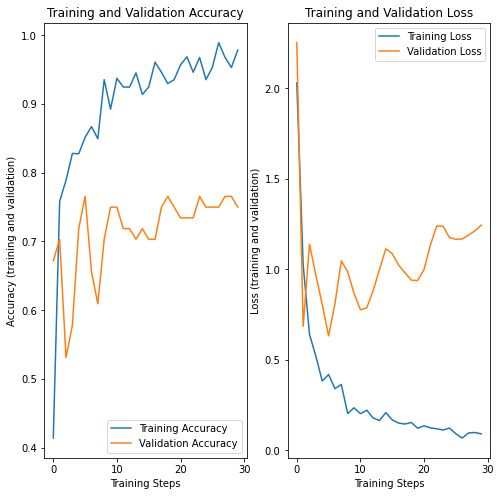

In [90]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [91]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_012.png
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.493930


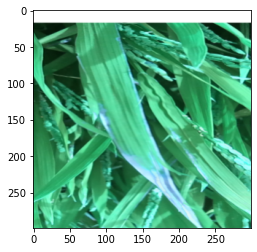

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_037.JPG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.528959


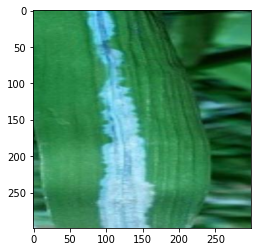

SOURCE: class: blast, file: blast/blast_rotated_022.png
PREDICTED: class: blast, confidence: 0.989687


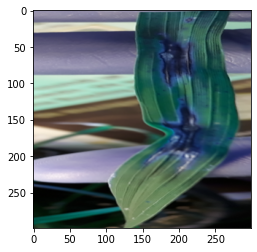

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_025.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.807520


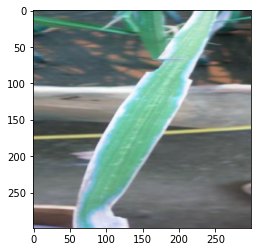

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_016.png
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.493930


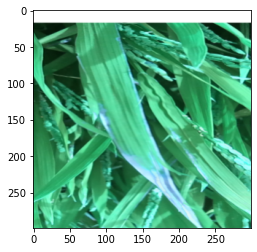

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_031.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.648520


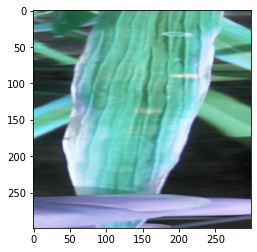

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_028.PNG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.722820


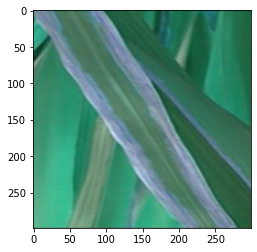

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_001.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.961045


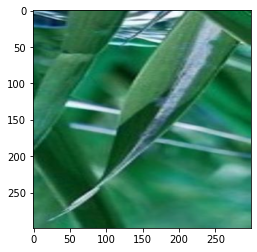

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_003.jpg
PREDICTED: class: brownspot, confidence: 0.998755


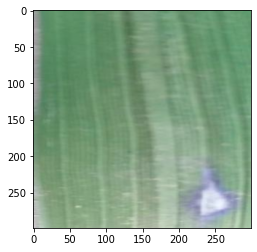

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_005.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.657721


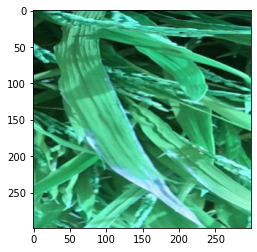

<Figure size 432x288 with 0 Axes>

In [93]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()